In [1]:
# Access astronomical databases
from pyvo import registry  # version >=1.4.1 

# Moc and HEALPix tools
from mocpy import MOC

# Sky visualization
from ipyaladin import Aladin

import numpy as np

import pandas as pd
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

In [6]:
%%time
# the catalogue name in VizieR
CATALOGUE = "J/ApJS/249/18"

# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"
# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

tables_names = list(tables.keys())

# get the first table of the catalogue
first_table_name = tables_names[1]

# execute a synchronous ADQL query
tap_service = voresource.get_service("tap")
tap_records = voresource.get_service("tap").run_sync(
f'SELECT * FROM "{first_table_name}"',)

CPU times: user 1min 9s, sys: 746 ms, total: 1min 10s
Wall time: 1min 13s


In [8]:
len(tap_records)

781602

In [11]:
data = tap_records.to_table()

In [ ]:
#%%time
#data.write("/epyc/ssd/users/atzanida/tmp/ztf_periodic.ascii", format='ascii')

Text(0, 0.5, 'Amp$_{ZTF-r}$')

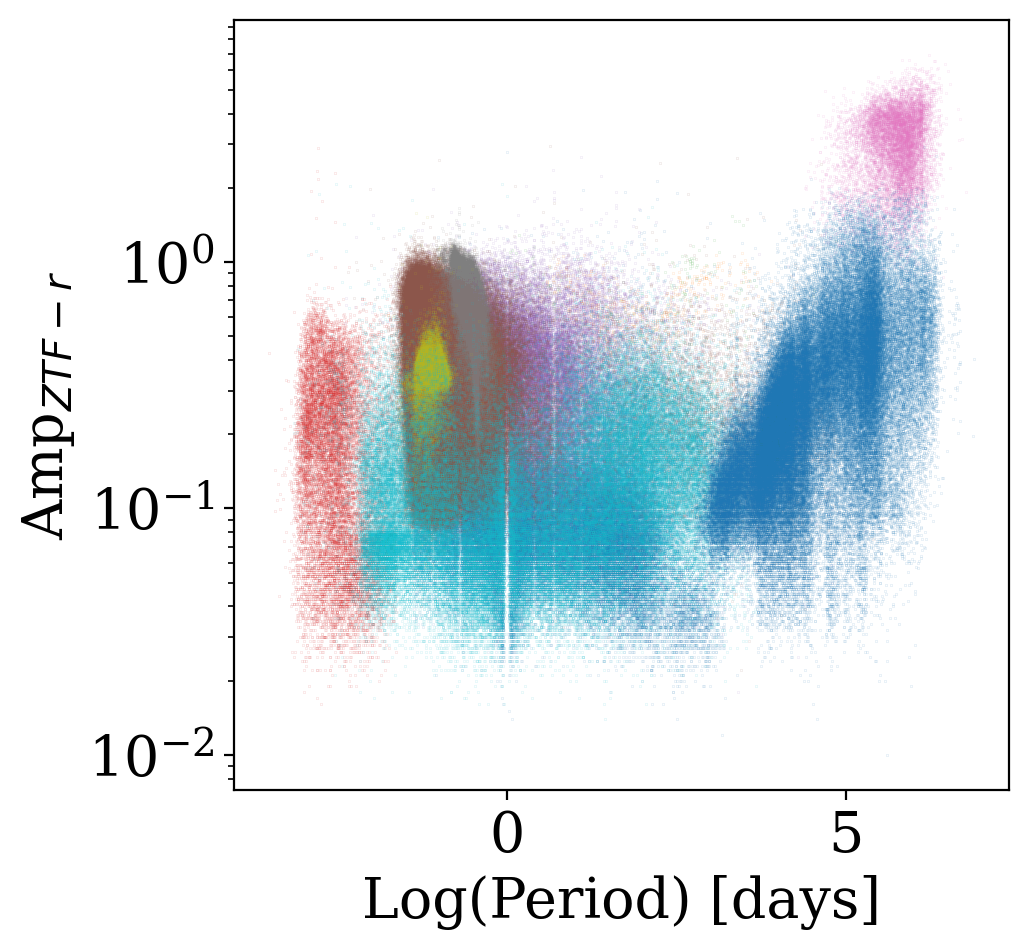

In [36]:
plt.figure(figsize=(5,5))
for uq in np.unique(data['Type']):
    w = data['Type']==uq
    plt.scatter(np.log(data['Per'][w]), data['rAmp'][w], s=0.001)
    
plt.yscale('log')
plt.xlabel("Log(Period) [days]")
plt.ylabel("Amp$_{ZTF-r}$")
    

## Feature Calculator


### STEPS FOR ANALYSIS 
1. Conver periodic table to hipscat for crossmatch to ZTF source and object.
2. Calculate features



### Light Curve Scoring System

$$\begin{equation} \text{Score} = \frac{1}{N_{dip}} \sum_{i=i}^{N_{dip}} \delta_{dev} \times \Delta T \times n_{dip} \times I_{\text{score}}\end{equation}$$

In [2]:
table_path = "/epyc/ssd/users/atzanida/tmp/ztf_periodic.ascii"
ztf_periodic = Table.read(table_path, format='ascii').to_pandas()

In [3]:
ztf_periodic.reset_index(drop=True, inplace=True)

In [4]:
ztf_periodic.head(1)

,recno,ID,Seq,RAJ2000,DEJ2000,Per,R21,phi21,T0,gmag,...,phi21-r,R2-g,R2-r,gAmp,rAmp,log(FAP-g),log(FAP-r),Type,Dmin-g,Dmin-r
0,61302,ZTFJ030001.97+010340.8,61302,45.00823,1.06134,0.385842,0.183,6.342,58523.143107,15.742,...,6.342,0.974,0.985,0.397,0.372,-9.147,-10.839,EW,0.046,0.046


In [5]:
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


## Hipscat ZTF Periodic

In [6]:
%%time
hips_periodic = lsdb.from_dataframe(ztf_periodic, catalog_name='ZTFPeriodic',
                                   catalog_type="object",
                                   ra_column="RAJ2000",
                                   dec_column="DEJ2000")

CPU times: user 5min 25s, sys: 5.18 s, total: 5min 30s
Wall time: 5min 30s


In [7]:
hips_periodic

,recno,ID,Seq,RAJ2000,DEJ2000,Per,R21,phi21,T0,gmag,rmag,Per-g,Per-r,Ng,Nr,R21-g,R21-r,phi21-g,phi21-r,R2-g,R2-r,gAmp,rAmp,log(FAP-g),log(FAP-r),Type,Dmin-g,Dmin-r,Norder,Dir,Npix
npartitions=27,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,string,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string,float64,float64,uint8,uint64,uint64
288230376151711744,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [8]:
# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

In [9]:
ztf

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=2352,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [10]:
combo = ztf.crossmatch(hips_periodic, radius_arcsec=1) # ZTF with periodic

In [11]:
%%time
combo.compute()

CPU times: user 36min 49s, sys: 16min 8s, total: 52min 57s
Wall time: 2min 50s


,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,...,rAmp_ZTFPeriodic,log(FAP-g)_ZTFPeriodic,log(FAP-r)_ZTFPeriodic,Type_ZTFPeriodic,Dmin-g_ZTFPeriodic,Dmin-r_ZTFPeriodic,Norder_ZTFPeriodic,Dir_ZTFPeriodic,Npix_ZTFPeriodic,_dist_arcsec
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
277184367296512,109270450082003814,45.008236,1.061349,15.877600,15.609200,15.489600,589,633,18,15.761877,...,0.372,-9.147,-10.839,EW,0.046,0.046,1,0,0,0.041169
309765456527360,109080458044257148,45.804427,0.905565,15.517100,15.791400,13.592200,322,375,0,17.016349,...,3.845,-10.430,-12.328,Mira,0.000,0.000,1,0,0,0.022115
355149335756800,109160460555839801,46.055571,0.974488,18.608900,18.025600,18.068701,547,595,17,18.465317,...,0.435,-8.206,-9.514,RR,0.000,0.000,1,0,0,0.027300
407146831282176,109510460340003115,46.034005,1.260508,14.395400,13.446000,12.939000,292,321,0,14.450968,...,0.517,-3.732,-5.751,EW,0.148,0.129,1,0,0,0.046338
576537292177408,108940443228882730,44.322900,0.785249,18.958500,18.530899,18.496700,367,376,17,18.747360,...,0.600,-1.000,-1.928,RR,0.000,0.000,1,0,0,0.050382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13834797062849298432,106833150991130333,315.099070,-0.975093,16.139400,15.116300,14.599800,232,310,41,16.137507,...,0.103,-3.443,-3.663,BYDra,0.000,0.000,0,0,11,0.012142
13834821324674957312,106883147178528468,314.717814,-0.926624,17.948601,17.821800,18.076099,231,299,39,18.074440,...,0.359,-4.787,-5.649,RRc,0.000,0.000,0,0,11,0.030376
13834939094725033984,107253148238386286,314.823853,-0.620153,18.895300,18.621901,18.664000,213,277,35,18.930871,...,0.359,-1.414,-3.104,EW,0.198,0.098,0,0,11,0.858129


In [12]:
%%time
_sources = combo.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/dask/join_catalog_data.py:195: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 2min 12s, sys: 7.28 s, total: 2min 20s
Wall time: 2min 19s


In [13]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper
pd.options.mode.chained_assignment = None

# Initialize an Ensemble
ens = Ensemble(n_workers=15, threads_per_worker=1)
ens.client_info()

In [14]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=combo._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

In [80]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from evaluate import half_eval as half_eval
from gpmcmc import model_gp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Example Light Curve Single Source

In [35]:
combo._ddf.head(1, npartitions=3)['Per-g_ZTFPeriodic']

_hipscat_index
277184367296512    0.385853
Name: Per-g_ZTFPeriodic, dtype: float64

In [89]:
lc = ens.source.loc[277184367296512]

In [90]:
lc = lc.compute()

In [91]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

Text(0, 0.5, 'Apparent Mag.')

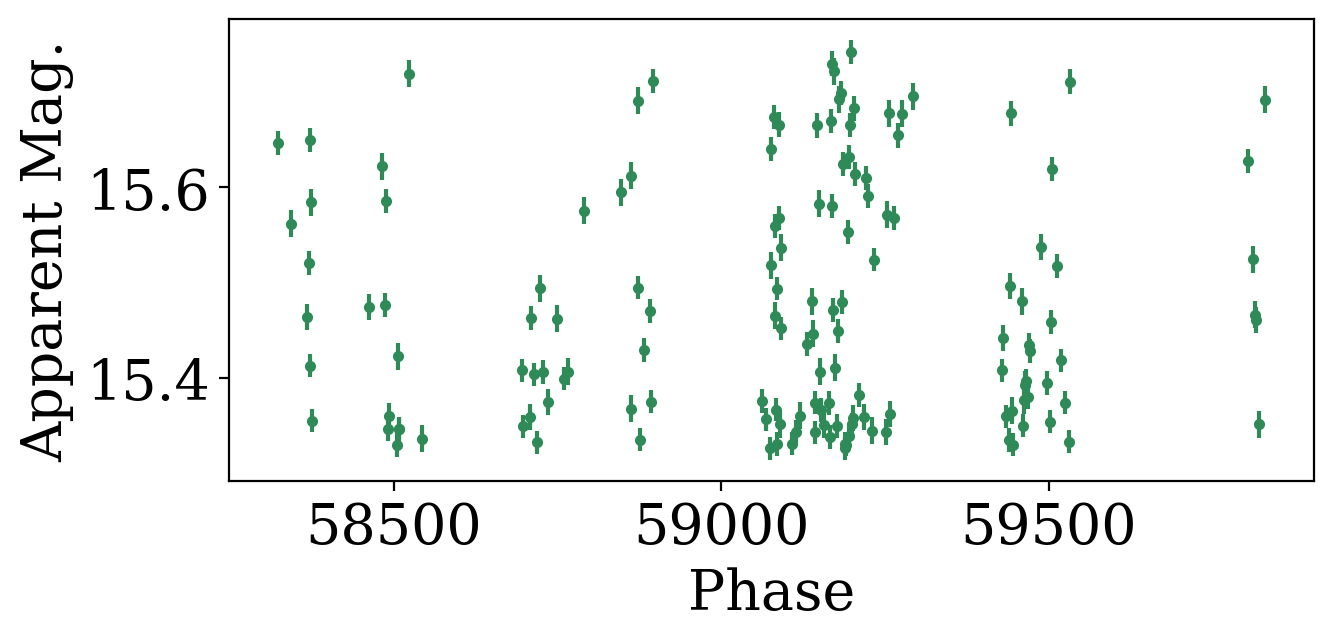

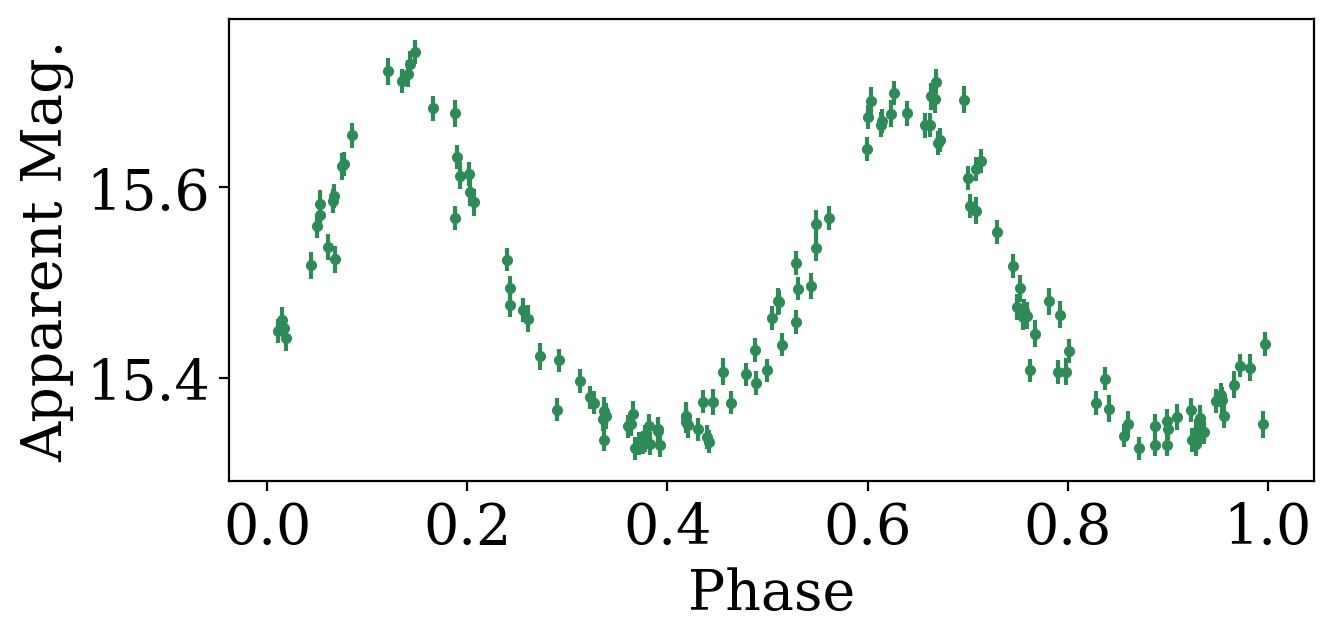

In [92]:
plt.figure(figsize=(7, 3))
plt.errorbar(time, mag, yerr=magerr, fmt='.', color='seagreen')
plt.xlabel("Phase")
plt.ylabel("Apparent Mag.")


plt.figure(figsize=(7, 3))
plt.errorbar((time%0.385853)/0.385853, mag, yerr=magerr, fmt='.', color='seagreen')
plt.xlabel("Phase")
plt.ylabel("Apparent Mag.")


In [95]:
half_eval(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0])

(1,
 {'dip_0': {'peak_loc': 59197.23849,
   'window_start': 59195.19663,
   'window_end': 59200.24215,
   'N_1sig_in_dip': 3,
   'N_in_dip': 3,
   'loc_forward_dur': 2.0418600000048173,
   'loc_backward_dur': 3.003659999994852,
   'dip_power': 2.0800157,
   'average_dt_dif': 0}})

### Explore Cadences with Unique Signals

In [233]:
min(time), max(time), np.mean(time)

(58323.48324, 59829.47725, 59088.16649965278)

In [910]:
y = dip_models.skew_norm(time, 59088, 3, -0, 14, 1)
y += dip_models.skew_norm(time, 59088+50, 3, 0, 14, 1)
y += dip_models.skew_norm(time, 59088+130, 3, 0, 0, 0.7)
#y += dip_models.skew_norm(time, 58500+250, 12, 1, 0, 0.9)
y += dip_models.skew_norm(time, 58500+350, 12, 1, 0, 0.9)
#y += dip_models.skew_norm(time, 58500+250, 1, 1, 0, 3)
#y -= 12

y += np.random.normal(0, 0.01, len(y))


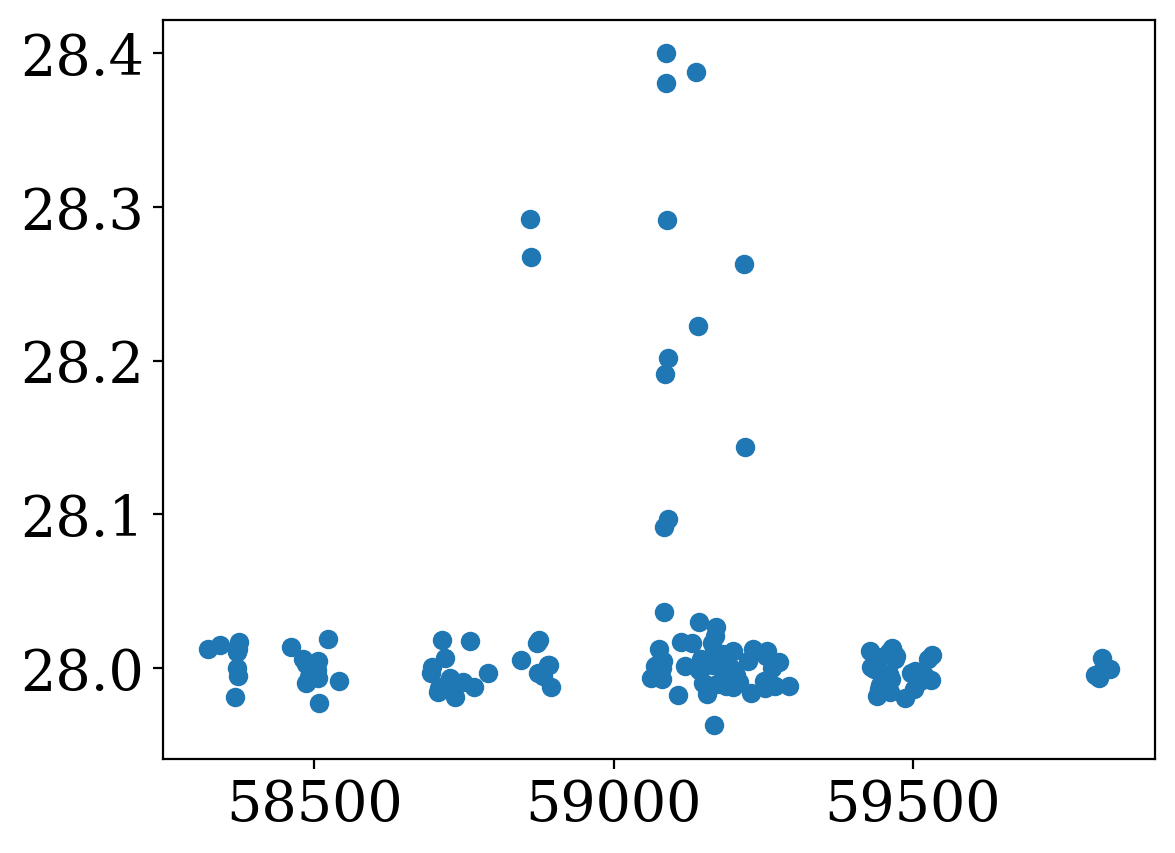

In [911]:
plt.scatter(time, y)

In [912]:
R, S = astro_stats.biweight.biweight_location(y), astro_stats.biweight.biweight_scale(y)
Dev = dip_pipeline.deviation(y, magerr, R, S)

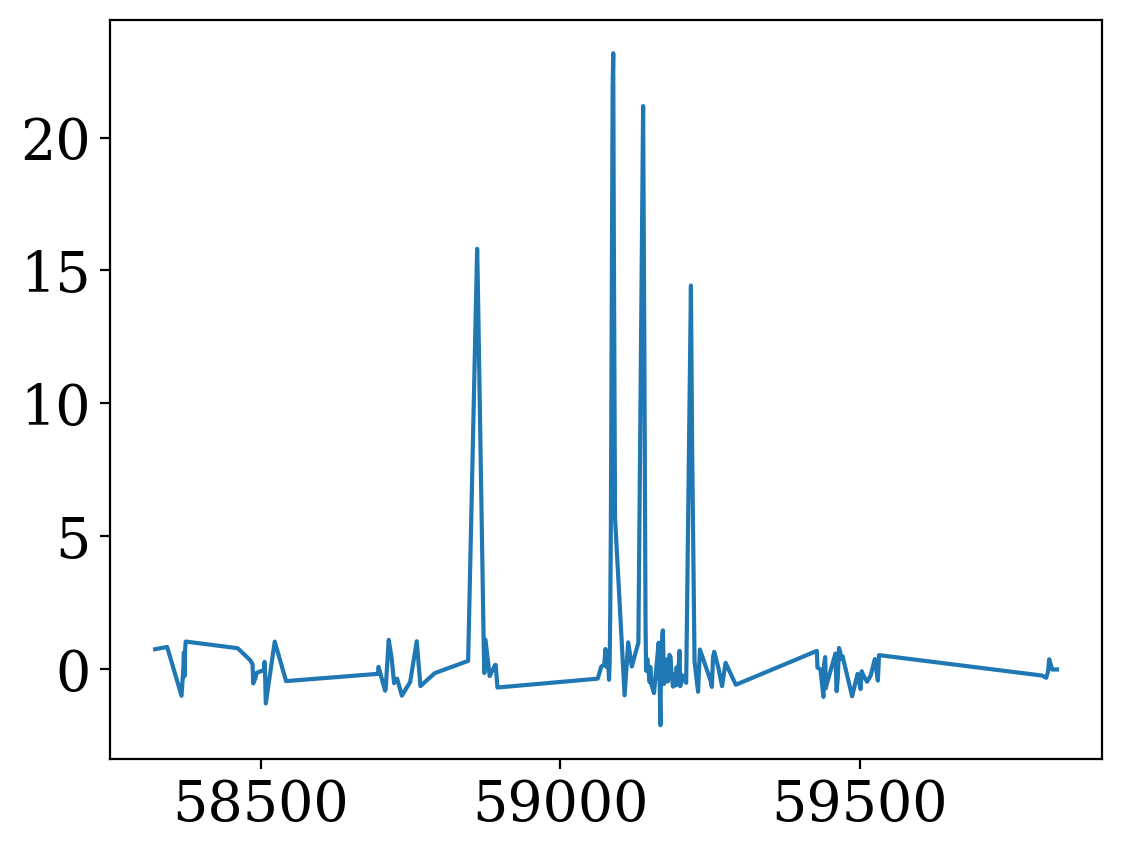

In [913]:
plt.plot(time, Dev)

In [914]:
je = half_eval(time, 
          y, 
               magerr,
          np.zeros(len(time)),
        np.array(['r' for _ in range(len(time))]), lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0])

In [915]:
je[0]

4

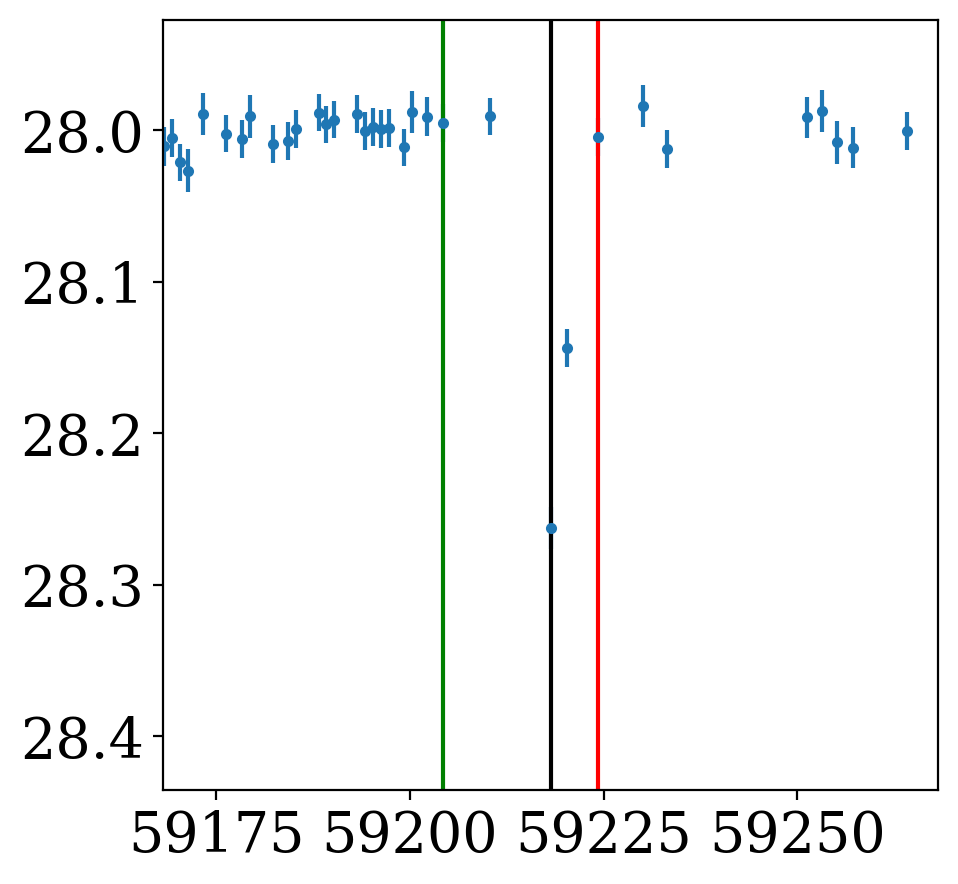

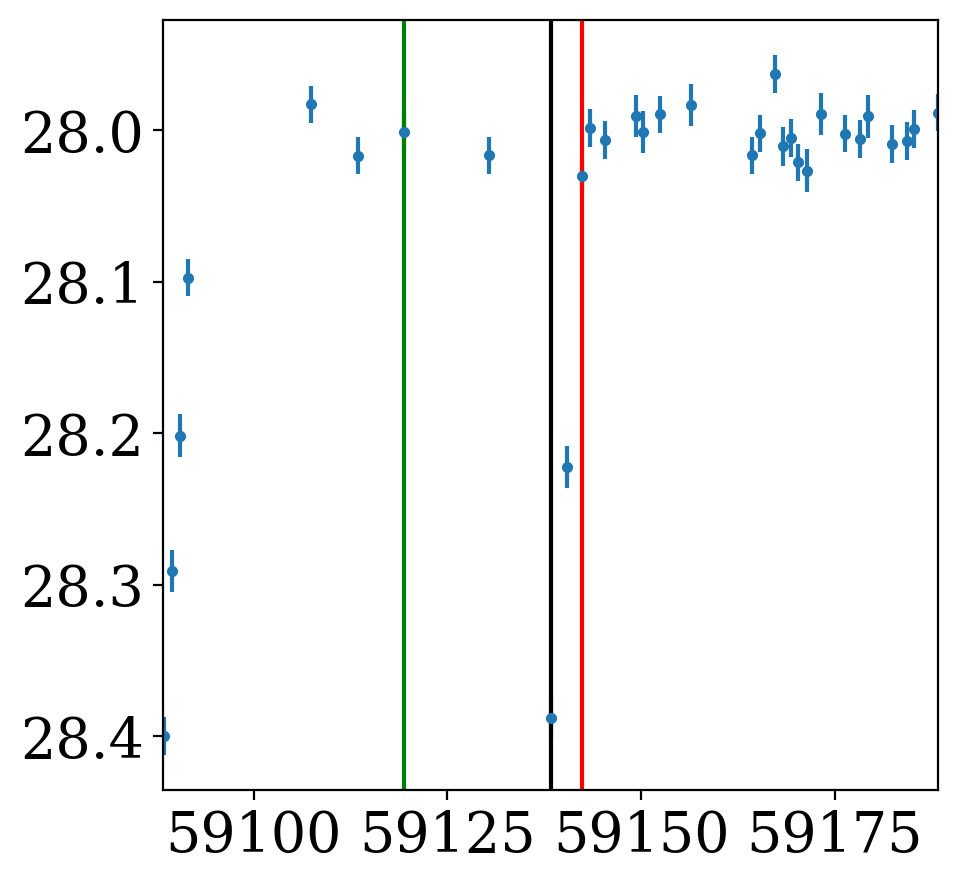

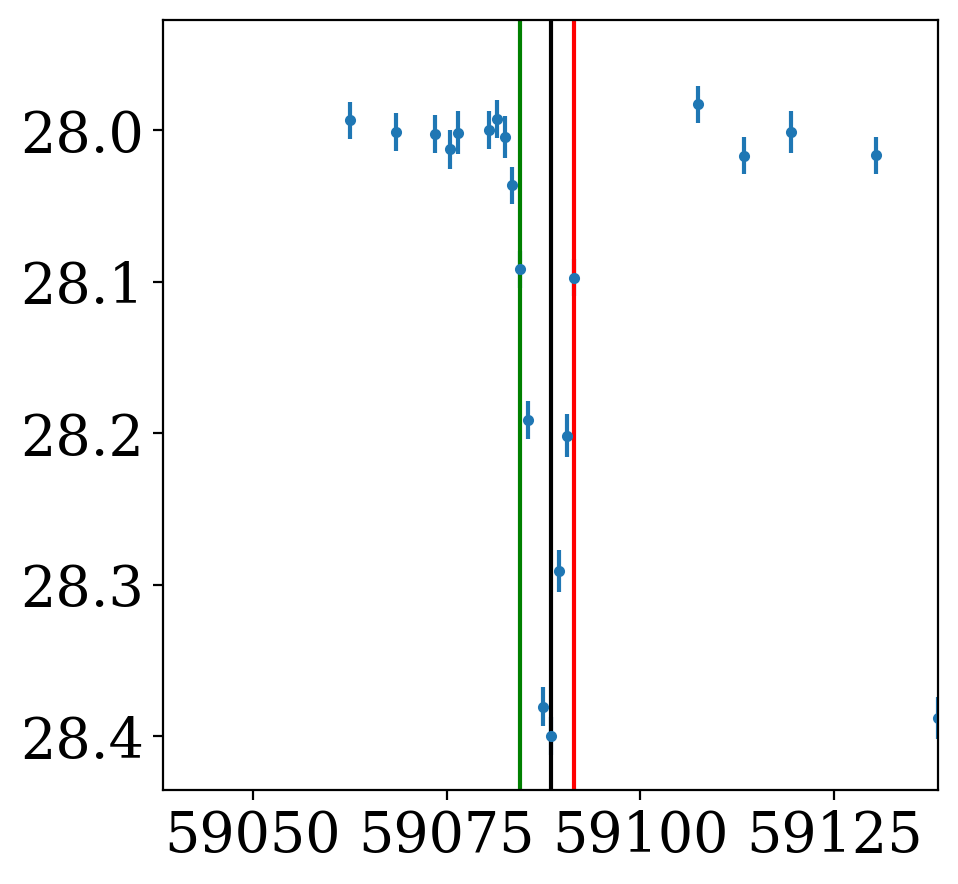

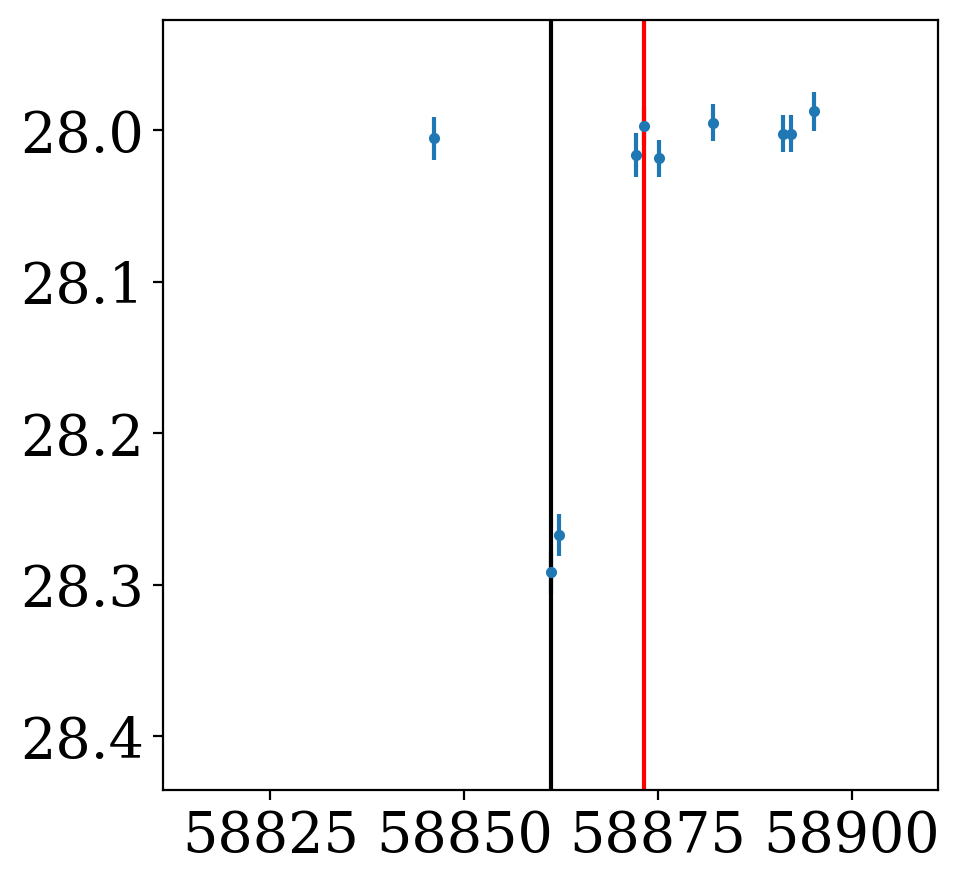

In [916]:
for i in range(je[0]):
    plt.figure(figsize=(5,5))
    plt.errorbar(time, y, yerr=magerr, fmt='.')
    plt.ylim(plt.ylim()[::-1])
    plt.axvline(je[1][f'dip_{i}']['peak_loc'],color='k')
    plt.axvline(je[1][f'dip_{i}']['window_start'],color='green')
    plt.axvline(je[1][f'dip_{i}']['window_end'],color='red')
    plt.xlim(je[1][f'dip_{i}']['peak_loc']-50, je[1][f'dip_{i}']['peak_loc']+50)


$$\begin{equation} \text{Score} = \frac{1}{N_{dip}} \sum_{i=i}^{N_{dip}} \delta_{dev} \times \Delta T \times n_{dip} \times I_{\text{score}}\end{equation}$$

In [917]:
import gpmcmc as modeling_gps

In [918]:
import astropy.stats as astro_stats

CPU times: user 80.5 ms, sys: 8.83 ms, total: 89.3 ms
Wall time: 87.8 ms


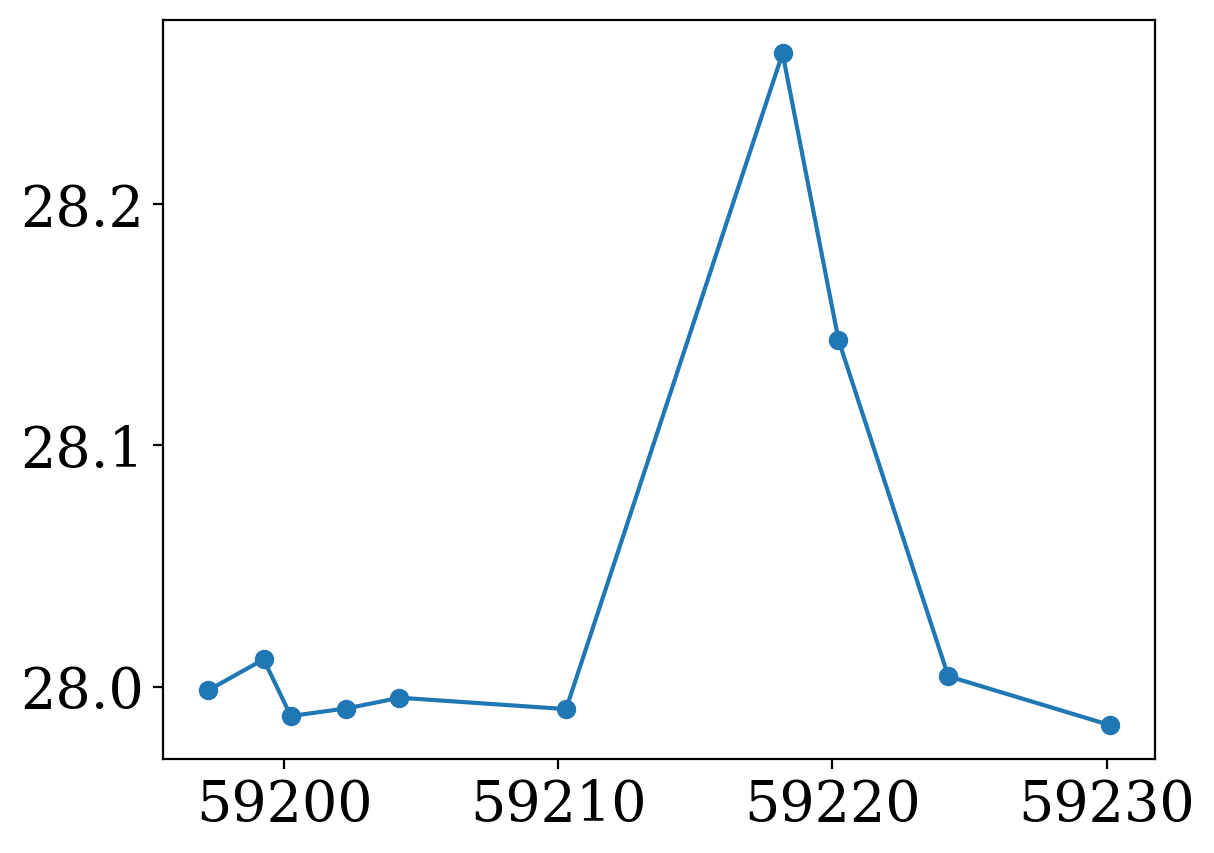

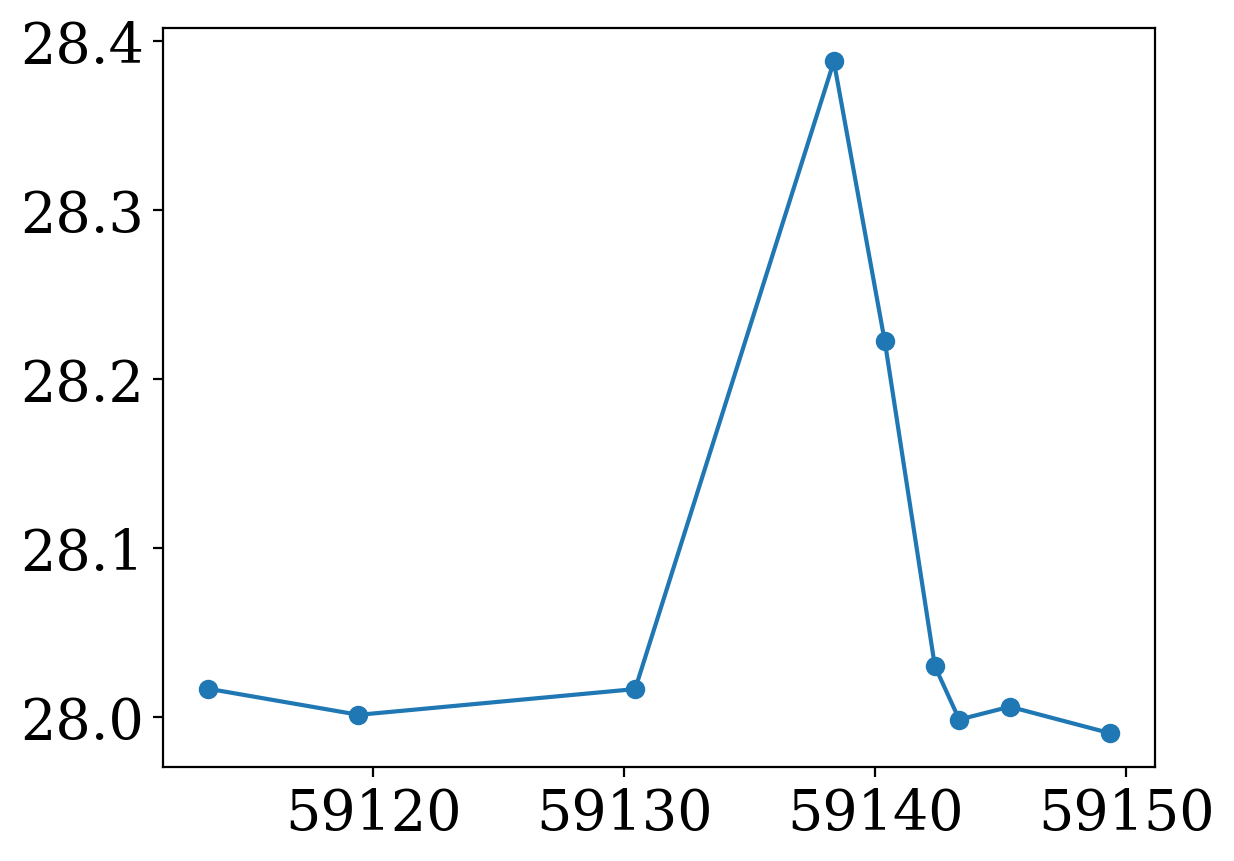

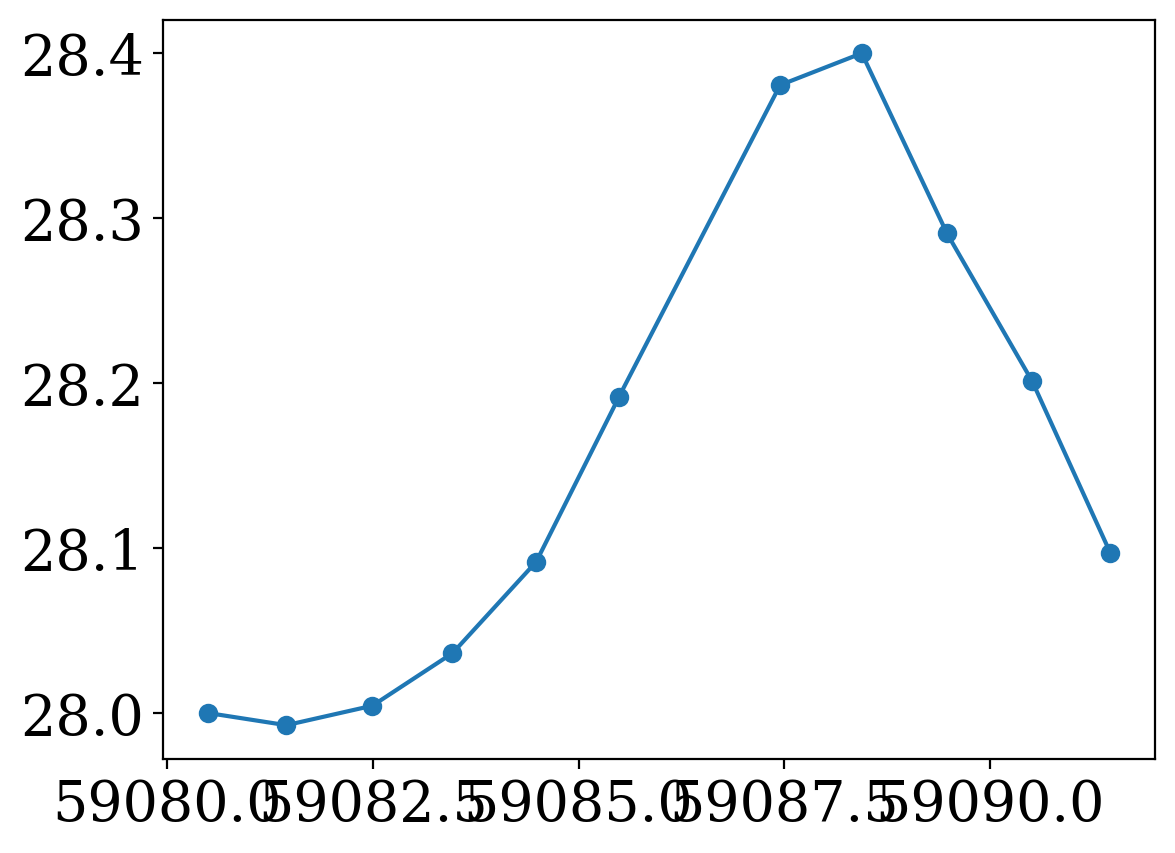

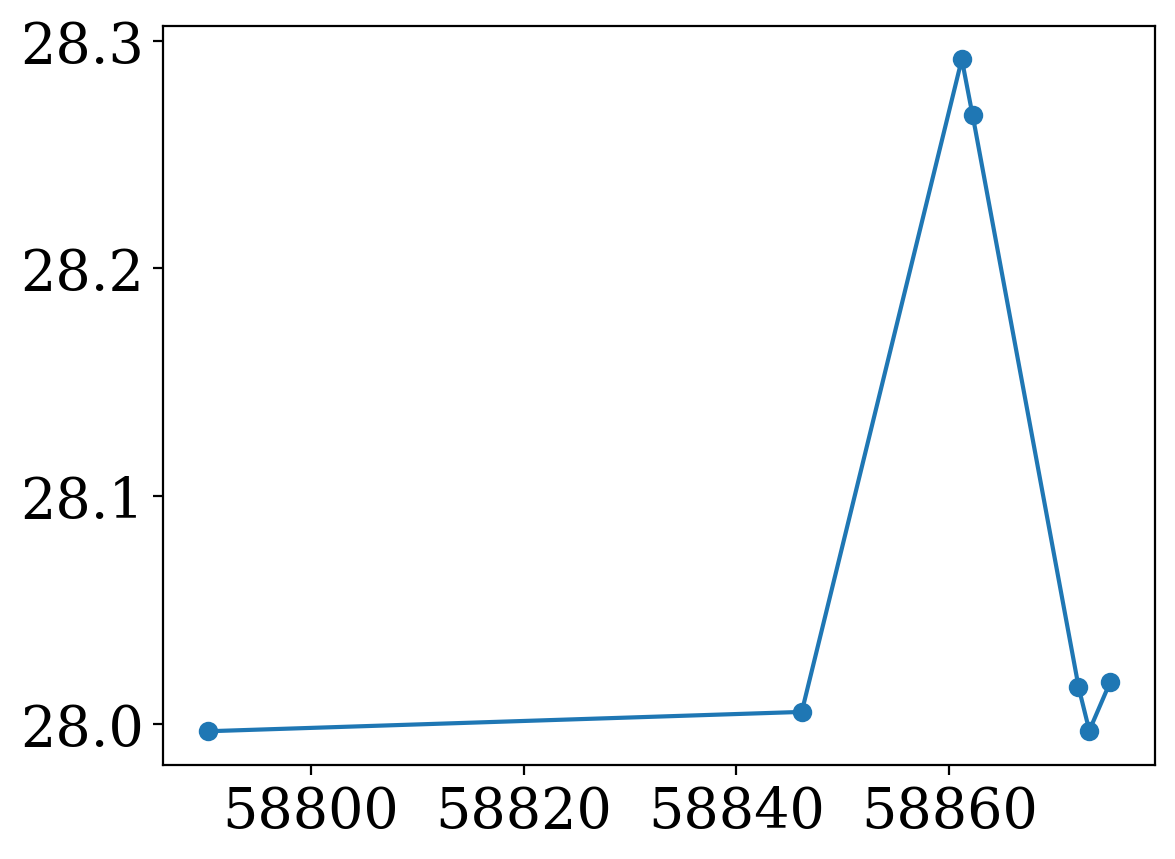

In [919]:
%%time
Iscors = []
for j in range(je[0]):
    
    xt, yt, yerrt = my_tools.digest_the_peak(je[1][f'dip_{j}'], time, y, magerr, expandby=7)
    #gp1 = modeling_gps.simple_GP(xt, yt, yerrt, ell=0.1)
    gp1 = modeling_gps.simple_linear_interp(xt, yt, yerrt)
    
    plt.figure()
    plt.scatter(xt, yt)
    plt.plot(gp1[0], gp1[1])
    so = dip_pipeline.evaluate_dip(gp1, xt, yt, yerrt, R, S, je[1][f'dip_{j}']['peak_loc'])
    _s = dip_pipeline.evaluate_dip(gp1, xt, yt, yerrt, R, S, je[1][f'dip_{j}']['peak_loc'])['assymetry_score']
    Iscors.append(_s)

In [920]:
C = 0 
for jj in range(je[0]):
    try:
        C += je[1][f'dip_{jj}']['dip_power'] * \
            (je[1][f'dip_{jj}']['window_end']-je[1][f'dip_{jj}']['window_start']) * \
            (je[1][f'dip_{jj}']['N_1sig_in_dip']) * abs(Iscors[jj])
    except:
        break

In [896]:
print (f"Final Score: {1/je[0] * (C)}") # one very skewed other direction!!!

Final Score: 175673.32431339583


In [877]:
print (f"Final Score: {1/je[0] * (C)}") # one very skewed!!!

Final Score: 487115.92051423


In [864]:
print (f"Final Score: {1/je[0] * (C)}") # one with outlier!!!!

Final Score: 108314.26771566752


In [813]:
print (f"Final Score: {1/je[0] * (C)}") # one event

Final Score: 252513.3863304554


In [826]:
print (f"Final Score: {1/je[0] * (C)}") # two events

Final Score: 102495.52082112014


In [789]:
print (f"Final Score: {1/je[0] * abs(C)}") # 3 events

Final Score: 53325.710932025


In [921]:
print (f"Final Score: {1/je[0] * abs(C)}") # 4 events

Final Score: 95237.37355331396
